# How to perform aperture photometry with custom apertures

## Learning goals

We have discussed in [previous tutorials](Aperture-Photometry-Tutorial.htm) how Simple Aperture Photometry works (SAP). A set of pixels in the image are chosen and we sum those to produce a single flux value. We sum the same pre-selected pixels for every image at each time slice to produce a light curve.

The [SPOC](https://github.com/nasa/kepler-pipeline) produces an aperture, which is used by default by *Lightkurve*. However, there are some cases where you might want to produce your own aperture. The field may be crowded, or you may wish to change the aperture size to change the relative contribution of the background. Lightkurve offers tools to select pixels programmatically.

First, let's load a target pixel file. Let's choose Gaia object DR25290850609994130560. This object was observed in TESS FFI data. We'll use the [`search_tesscut`](https://docs.lightkurve.org/api/lightkurve.search.search_tesscut.html) function to download a cut out of the target in a single sector. You can determine which sectors the target was observed in using the [MAST TESS portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html).

## Imports
This tutorial requires:
- **[Lightkurve](https://docs.lightkurve.org)** 
- [**Matplotlib**](https://matplotlib.org/) 
- [**numpy**](https://numpy.org)

In [1]:
%matplotlib inline 
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

## Downloading data
Lets see when Gaia object DR25290850609994130560 was observed.

In [2]:
search_result = lk.search_tesscut('Gaia DR25290850609994130560')
print(search_result)

SearchResult containing 5 data products.

 #   observation   author         target_name         productFilename distance
--- -------------- ------ --------------------------- --------------- --------
  0  TESS Sector 4   MAST Gaia DR25290850609994130560         TESSCut      0.0
  1  TESS Sector 7   MAST Gaia DR25290850609994130560         TESSCut      0.0
  2  TESS Sector 8   MAST Gaia DR25290850609994130560         TESSCut      0.0
  3  TESS Sector 9   MAST Gaia DR25290850609994130560         TESSCut      0.0
  4 TESS Sector 10   MAST Gaia DR25290850609994130560         TESSCut      0.0


We can see that this object is detected in Sectors  4, 7, 8, 9, and 10. You can download data from just one sector and specify the cutout_size in number of TESS pixels on a side as an argument to `.download()`. The default is a meager 5 × 5 square. Let’s go with 10 pixels square.

In [3]:
search_result = lk.search_tesscut('Gaia DR25290850609994130560', sector=8)
tpfs = search_result.download(cutout_size=10)
print(tpfs)

TessTargetPixelFile(TICID: Gaia DR25290850609994130560)


We now have a TessTargetPixelFile object that we can examine.

## Examine the data 

Lets plot the data.

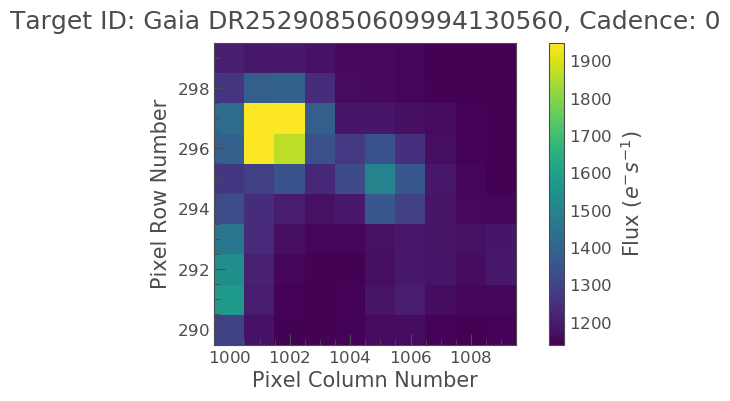

In [4]:
tpfs.plot();

Our object of interest should be located at the center of the image. There however appears to be a bright star near by, is this our object? We can check by using the [interact_sky](https://docs.lightkurve.org/api/lightkurve.targetpixelfile.KeplerTargetPixelFile.html?highlight=interact_sky#lightkurve.targetpixelfile.KeplerTargetPixelFile.interact_sky) function which can overlay Gaia objects. 

In [13]:
tpfs.interact_sky(magnitude_limit=14)

By adjusting the screen stretch below and moving our pointer over the red circles we can see that our object of interest is indeed the center object and not the bright object. 

Because we created this TPF from a FFI there is no predefined SPOC aperture and as such we have to make our own. We can do this via the [`create_threshold_mask`](https://docs.lightkurve.org/api/lightkurve.targetpixelfile.TessTargetPixelFile.html?highlight=create_threshold_mask#lightkurve.targetpixelfile.TessTargetPixelFile.create_threshold_mask). This method will identify the pixels in the TPF which show a median flux that is brighter than threshold times the standard deviation above the overall median. The standard deviation is estimated in a robust way by multiplying the Median Absolute Deviation (MAD) with 1.4826. In this example we will pick 10 as our threshold.

In [14]:
target_mask = tpfs.create_threshold_mask(threshold=10, reference_pixel='center')
n_target_pixels = target_mask.sum()
n_target_pixels

4

Lets now plot this up and see what it looks like.

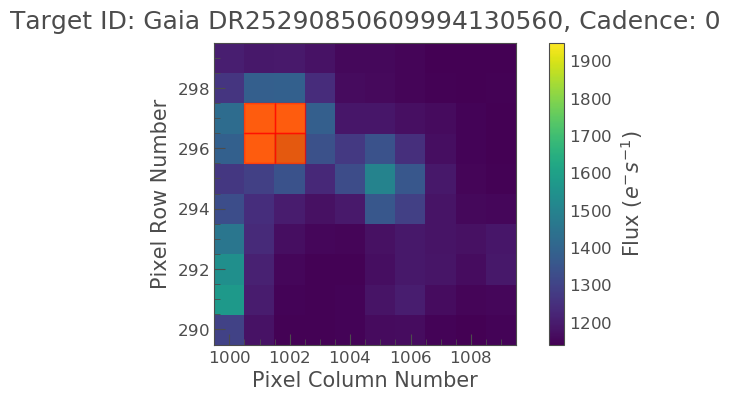

In [15]:
tpfs.plot(aperture_mask=target_mask, mask_color='r');

Oh no! It looks like the bright object next to our object of interest was covered, not our object. We have to correct this. We can do this K it looks like our object is covered nicely by the aperture, lets see what the light curve looks like!

## Specify an aperture array
We need to define a new aperture array such that our aperture will cover our object of interest. In our [previous tutorial](Aperture-Photometry-Tutorial.html) we learn that aperture arrays are boolean, based on this lets make up a new array.

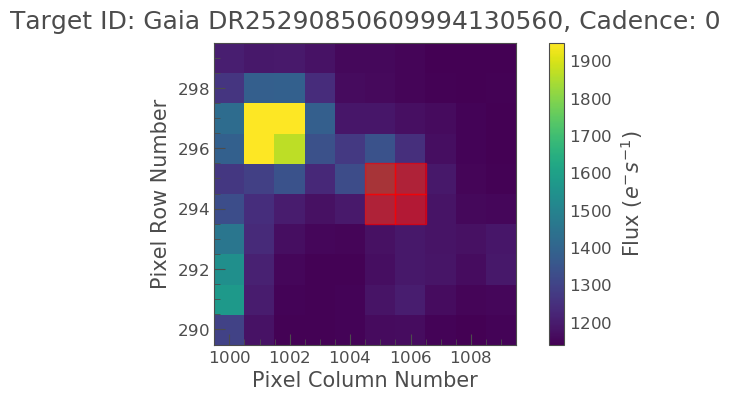

In [16]:
aper_new = np.zeros(tpfs.shape[1:], dtype=bool)
aper_new[4:6, 5:7] = True
tpfs.plot(aperture_mask=aper_new, mask_color='red')

Ok that is much better. Lets take a look at the light curve data using this aperture.

In [17]:
target_lc = tpfs.to_lightcurve(aperture_mask=target_mask)
print(target_lc)

       time               flux            flux_err      ... cadenceno quality
                      electron / s      electron / s    ...                  
------------------ ----------------- ------------------ ... --------- -------
1517.3666381835938   8007.5966796875 2.5630364418029785 ...         0    2048
1517.3875122070312  7244.67626953125  2.450223445892334 ...         1    2048
1517.4083251953125    6630.228515625  2.352027654647827 ...         2       0
1517.4291381835938    6195.158203125  2.283012628555298 ...         3       0
1517.4500122070312     5870.74609375 2.2279577255249023 ...         4       0
1517.4708251953125  5619.29345703125 2.1846823692321777 ...         5       0
1517.4916381835938    5409.947265625 2.1488730907440186 ...         6       0
1517.5125122070312    5226.427734375 2.1181600093841553 ...         7       0
1517.5333251953125   5080.0048828125 2.0899178981781006 ...         8       0
1517.5541381835938   4946.3740234375  2.065858840942383 ...     

Great! Now lets plot this light curve. 

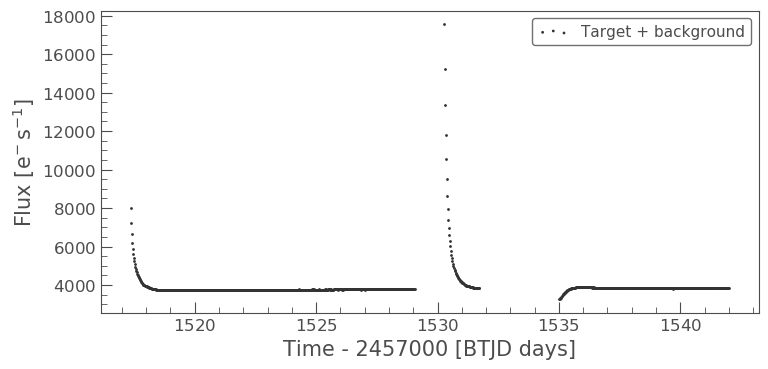

In [18]:
target_lc.scatter(label='Target + background')

Above we see that the object looks to have some sort of variability. There also appears to be some sort of data gap. What is this caused by? Lets check the [TESS Data Release Notes](https://archive.stsci.edu/missions/tess/doc/tess_drn/tess_sector_08_drn10_v02.pdf) for sector 8. If we look at this we see that there was an instrument anomaly starting on 1531 and ending 1535.  This explains some of issues we are seeing.

What about the two bright peaks though, this is unlikely from our object of interest. It might be useful to visually inspect these cadences to better understand what is happening. We can learn how to do this in the [next tutorial!](Visual-inspection-Tutorial.html)